In [1]:
!pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 27.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

In [3]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

In [4]:
corpus_path = 'corpus.csv'
df = pd.read_csv(corpus_path, encoding='utf-8')
df['text'] = df['Title'] + '. ' + df['Body']

In [5]:
df.head()

,Year,Title,Body,Category,text
0,1979,yoashico inca,"ja rekena inkan jane ronki ipaonike, yoashiko ...",cuento,yoashico inca. ja rekena inkan jane ronki ipao...
1,1979,yoashico incan jato jascara apaoni,ikonbires jakonma ronki ipaonike yoashiko inka...,cuento,yoashico incan jato jascara apaoni. ikonbires ...
2,1979,yoashico inca betan jahuen rayos ini,ja yoaxiko inka ronki rayossha ipaonike. ja ja...,cuento,yoashico inca betan jahuen rayos ini. ja yoaxi...
3,1979,jascatax manxanteo betan abobo jonini,"askara jakonma shinanya ixon ronki aka iki, ja...",cuento,jascatax manxanteo betan abobo jonini. askara ...
4,1979,inca baque miincani betan jenen ehuani,moa yoashiko inka reteax iiti chonka baritia p...,cuento,inca baque miincani betan jenen ehuani. moa yo...


In [6]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=[corpus_path], vocab_size=52000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

tokenizer.save_model(".", "shipibo_tokenizer")

['./shipibo_tokenizer-vocab.json', './shipibo_tokenizer-merges.txt']

In [7]:
from transformers import GPT2TokenizerFast

# Cargar el tokenizador desde los archivos vocab y merges
tokenizer = GPT2TokenizerFast(
    vocab_file="shipibo_tokenizer-vocab.json",
    merges_file="shipibo_tokenizer-merges.txt"
)

# Añadir tokens especiales
tokenizer.add_special_tokens({
    "pad_token": "<pad>",
    "unk_token": "<unk>",
    "mask_token": "<mask>",
    "bos_token": "<s>",
    "eos_token": "</s>",
})

# Verificar si se han añadido correctamente los tokens especiales
print("Tokens especiales añadidos:", tokenizer.special_tokens_map)

Tokens especiales añadidos: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'}


In [8]:
# Ejemplo de texto en Shipibo-Konibo
input_text = "Huestíora joni ronqui"
tokens = tokenizer.encode(input_text)
print("Tokens:", tokens)

# Des-tokenización
decoded_text = tokenizer.decode(tokens)
print("Texto decodificado:", decoded_text)

Tokens: [44, 89, 992, 88, 132, 260, 363, 321, 795, 85, 89, 77]
Texto decodificado: Huestíora joni ronqui


In [12]:
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

# Crear el modelo desde cero
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=1024,
    n_ctx=1024,
    n_embd=768,
    n_layer=12,
    n_head=12,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

model = GPT2LMHeadModel(config)

# Crear el dataset de Hugging Face
corpus_path = 'corpus.csv'
df = pd.read_csv(corpus_path)
df['text'] = df['Title'] + ' ' + df['Body']
dataset = Dataset.from_pandas(df[['text']])

# Tokenizar el corpus
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)




Map:   0%|          | 0/148 [00:00<?, ? examples/s]

In [13]:
train_testvalid = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_testvalid['train']
eval_dataset = train_testvalid['test']

In [20]:

# Crear el data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=1,  # Log cada paso
    eval_strategy="epoch",  # Evaluar cada época
    logging_strategy="epoch",  # Registrar cada época
)

# Inicializar el Trainer y entrenar el modelo
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset

)

In [21]:
from transformers import TrainerCallback
import math

class PerplexityAndLossCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []
        self.epoch_perplexities = []
        self.current_epoch_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            loss = logs['loss']
            self.current_epoch_loss.append(loss)

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.current_epoch_loss:
            avg_loss = sum(self.current_epoch_loss) / len(self.current_epoch_loss)
            perplexity = math.exp(avg_loss)
            self.epoch_losses.append(avg_loss)
            self.epoch_perplexities.append(perplexity)
            print(f"Epoch: {state.epoch}, Avg Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")
            self.current_epoch_loss = []  # Reset for the next epoch

# Crear y añadir el callback
callback = PerplexityAndLossCallback()
trainer.add_callback(callback)


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,4.486600,6.746872
2,4.200700,6.763107
3,3.934300,6.834075
4,3.677900,6.865092
5,3.459400,6.860995
6,3.219700,6.987869
7,3.046200,7.009742
8,2.822600,7.004290
9,2.685200,7.070112
10,2.514000,7.106730


Epoch: 2.0, Avg Loss: 4.4866, Perplexity: 88.8189
Epoch: 3.0, Avg Loss: 4.2007, Perplexity: 66.7330
Epoch: 4.0, Avg Loss: 3.9343, Perplexity: 51.1263
Epoch: 5.0, Avg Loss: 3.6779, Perplexity: 39.5632
Epoch: 6.0, Avg Loss: 3.4594, Perplexity: 31.7979
Epoch: 7.0, Avg Loss: 3.2197, Perplexity: 25.0206
Epoch: 8.0, Avg Loss: 3.0462, Perplexity: 21.0353
Epoch: 9.0, Avg Loss: 2.8226, Perplexity: 16.8205
Epoch: 10.0, Avg Loss: 2.6852, Perplexity: 14.6611
Epoch: 11.0, Avg Loss: 2.5140, Perplexity: 12.3542
Epoch: 12.0, Avg Loss: 2.3204, Perplexity: 10.1797
Epoch: 13.0, Avg Loss: 2.2930, Perplexity: 9.9046
Epoch: 14.0, Avg Loss: 2.1928, Perplexity: 8.9603
Epoch: 15.0, Avg Loss: 2.0606, Perplexity: 7.8507
Epoch: 16.0, Avg Loss: 1.9235, Perplexity: 6.8449
Epoch: 17.0, Avg Loss: 1.7815, Perplexity: 5.9388
Epoch: 18.0, Avg Loss: 1.6626, Perplexity: 5.2730
Epoch: 19.0, Avg Loss: 1.5368, Perplexity: 4.6497
Epoch: 20.0, Avg Loss: 1.4204, Perplexity: 4.1388
Epoch: 21.0, Avg Loss: 1.3032, Perplexity: 3.68

TrainOutput(global_step=1500, training_loss=1.3193434193929037, metrics={'train_runtime': 723.3201, 'train_samples_per_second': 8.157, 'train_steps_per_second': 2.074, 'total_flos': 1541622988800000.0, 'train_loss': 1.3193434193929037, 'epoch': 50.0})

In [39]:
# Guardar el modelo y el tokenizador
trainer.save_model("./train_model")  # Esto guarda el modelo, la configuración y el tokenizador
tokenizer.save_pretrained("./train_model")

('./train_model/tokenizer_config.json',
 './train_model/special_tokens_map.json',
 './train_model/vocab.json',
 './train_model/merges.txt',
 './train_model/added_tokens.json',
 './train_model/tokenizer.json')

In [40]:
# Cargar el modelo entrenado
model = GPT2LMHeadModel.from_pretrained('./train_model')


In [41]:
import re

def capitalize_sentences(text):
    sentences = re.split('(?<=[.!?]) +', text)  # Dividir el texto en oraciones
    capitalized_sentences = [sentence.capitalize() for sentence in sentences]
    return ' '.join(capitalized_sentences)

# Función para generar texto

def generate_story(prompt, max_length=512, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model.generate(
        inputs['input_ids'],
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,  # Para generar texto de manera más creativa
        top_k=50,  # Para limitar el número de palabras a considerar para cada paso
        top_p=0.95  # Para la estrategia de muestreo de núcleo (nucleus sampling)
    )

    stories = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    capitalized_stories = [capitalize_sentences(story) for story in stories]
    return capitalized_stories


# Ejemplo de uso
prompt = "moatian ronki ipaonike"
generated_stories = generate_story(prompt, max_length=300, num_return_sequences=3)


for i, story in enumerate(generated_stories):
    print(f"Cuento {i + 1}:\n{story}\n")

Cuento 1:
Moatian ronki ipaonike jatibi jawekibo joni ikatikanai, non rekenbo onanmabires. Jatian ronki aka iki jakiribi jawen rayos tana tanakin. Ikaxbi jawen awin wainkoki ika iki kikinbires shinan koshia. Jaskara ikaxki jawebi iamakatiai. Moa jatibitian jabicho aata ronki sinata iki. Jatian pikoxon oinna ika iki ja neteronki ika iki. Jatian jawen bene nosha mishkii kai. Jainoaxqki inka yoyo ika iki jakonmatani rabera en joniake. Ja awa koshichaayora ika iki. Jaskaxonki awakan ronon ewa bakeranon tesaa iki. Nemankinbi jawebi biamakana iki. Ja panshinshaman pikota iki jawen xeta; ja payonbiribi ika iki jawen texo iti. Ja jawen rayos kanwana pekao, chini jawen baken bene kaa iki; piaakin senenhaax, cakin, ninkata ikana iki. Jainxon mesko yoinabo keotai non ninkashina iki. Jaskara oinax jawen tita ikonbiressi winii sion sion ika iki. Jatian jakiribi bekana iki jen jen. Nete xabaketian, ja rao motsashon boa iki. Jaskaaxon ronki mananiihawen ino retea iki, ja joninki jiwi bixon marishkipa

# Métricas para evaluar el cuento generado

In [27]:
# Calcular la perplejidad
import math

def compute_perplexity(eval_dataset):
    eval_results = trainer.evaluate(eval_dataset)
    perplexity = math.exp(eval_results['eval_loss'])
    return perplexity

# Calcular la perplejidad
perplexity = compute_perplexity(tokenized_datasets)
print(f'Perplejidad: {perplexity}')


Perplejidad: 4.610558146759049


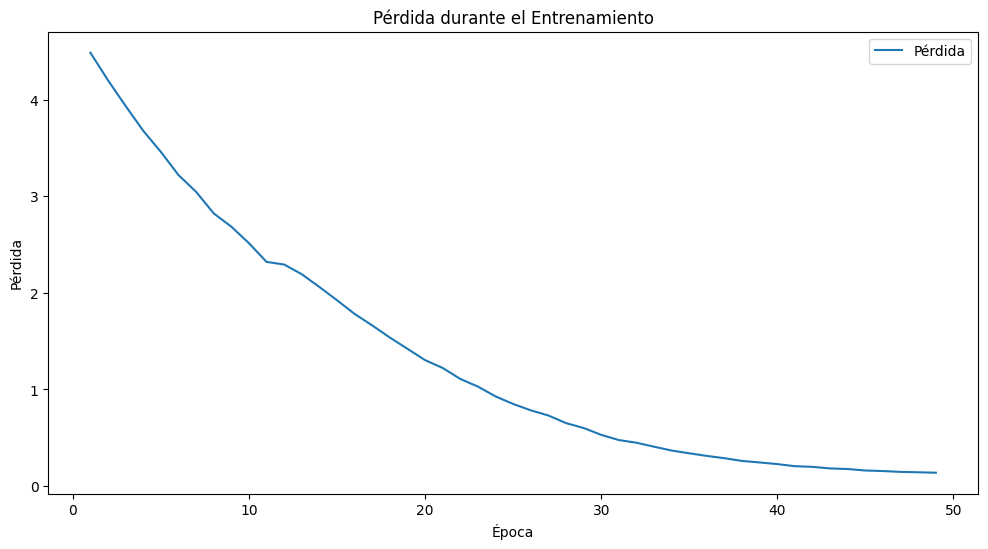

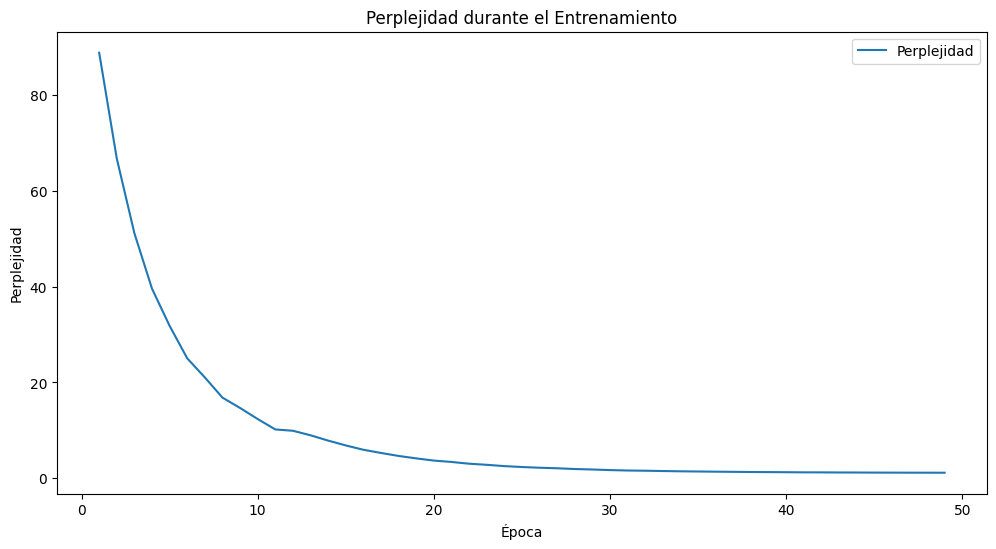

In [29]:
import matplotlib.pyplot as plt

# Extraer las pérdidas y perplejidades por época
epoch_losses = callback.epoch_losses
epoch_perplexities = callback.epoch_perplexities

# Graficar la pérdida
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()
plt.show()

# Graficar la perplejidad
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(epoch_perplexities) + 1), epoch_perplexities, label='Perplejidad')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.title('Perplejidad durante el Entrenamiento')
plt.legend()
plt.show()


#Creación de una API con Fast API

In [31]:
!pip install fastapi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [32]:
from fastapi import FastAPI
from pydantic import BaseModel
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch

app = FastAPI()

# Cargar el modelo y el tokenizador
model = GPT2LMHeadModel.from_pretrained('./results')
tokenizer = GPT2TokenizerFast.from_pretrained('./results')

class TextGenerationRequest(BaseModel):
    prompt: str
    max_length: int = 512
    num_return_sequences: int = 1

@app.post("/generate/")
async def generate_text(request: TextGenerationRequest):
    inputs = tokenizer(request.prompt, return_tensors='pt')
    outputs = model.generate(
        inputs['input_ids'],
        max_length=request.max_length,
        num_return_sequences=request.num_return_sequences,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )

    stories = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return {"stories": stories}

# Para ejecutar el servidor, usa: uvicorn main:app --reload
